# Profiling RGPD - Stages (2023-2025)

Objectif: comprendre la structure du CSV, mesurer la qualite, et identifier les risques RGPD avant toute transformation.

Pourquoi c'est important:
- On ne nettoie pas une donnee qu'on ne comprend pas.
- Le profiling revele les colonnes sensibles (PII), les valeurs manquantes, et les incoherences.
- On prend des decisions de nettoyage et d'anonymisation sur des faits, pas des suppositions.


In [1]:
import pandas as pd
from scripts.config import RAW_PATH, PII_COLUMNS


In [2]:
# Charger le CSV brut (separateur ';', encodage latin1)
df = pd.read_csv(RAW_PATH, sep=';', encoding='latin1')
df.shape


(3820, 11)

In [3]:
# Types et colonnes
df.dtypes


Programme           object
Promotion           object
Sujet               object
Domaine de stage    object
Société             object
Adresse société     object
Code postal         object
Ville               object
Pays                object
Nom étudiant        object
email étudiant      object
dtype: object

In [4]:
# Pourcentage de valeurs manquantes
missing_pct = (df.isna().mean() * 100).round(2)
missing_pct.sort_values(ascending=False)


Domaine de stage    27.91
Code postal          0.13
Société              0.05
Adresse société      0.05
Ville                0.05
Pays                 0.05
email étudiant       0.05
Programme            0.00
Promotion            0.00
Sujet                0.00
Nom étudiant         0.00
dtype: float64

In [5]:
# PII detectees selon la liste connue
pii_found = [c for c in df.columns if c in PII_COLUMNS]
pii_found


['Nom étudiant', 'email étudiant']

In [6]:
# Apercu sans PII (privacy first)
non_pii_cols = [c for c in df.columns if c not in PII_COLUMNS]
df[non_pii_cols].head(3)


,Programme,Promotion,Sujet,Domaine de stage,Société,Adresse société,Code postal,Ville,Pays
0,PREPA1,2023-2024,stage d´exécution L1,EXECUTION,Fondation de Coubertin,"Dom. de Coubertin, 78470 Saint-Rémy-lès-Chevreuse",78470,Saint-Rémy-lès-Chevreuse,FR
1,PREPA1,2023-2024,stage d´exécution L1,EXECUTION,SARL AMS SERVICES,Bâtiment G3 Place de Bel État Bat G,78280,Guyancourt,FR
2,PREPA1,2023-2024,stage d´exécution L1,EXECUTION,Cityz Media,24 Quai Alphonse Le Gallo,92100,Boulogne-Billancourt,FR


## Verification DuckDB

Cette section confirme que la table a bien ete chargee dans DuckDB.


In [7]:
import duckdb
from scripts.config import DUCKDB_PATH

con = duckdb.connect(str(DUCKDB_PATH), read_only=True)
con.execute("SELECT COUNT(*) AS nb_lignes FROM stages_clean").df()


,nb_lignes
0,3820


## Exemple de graphique DuckDB

Ce graphique prouve visuellement que DuckDB contient des donnees.


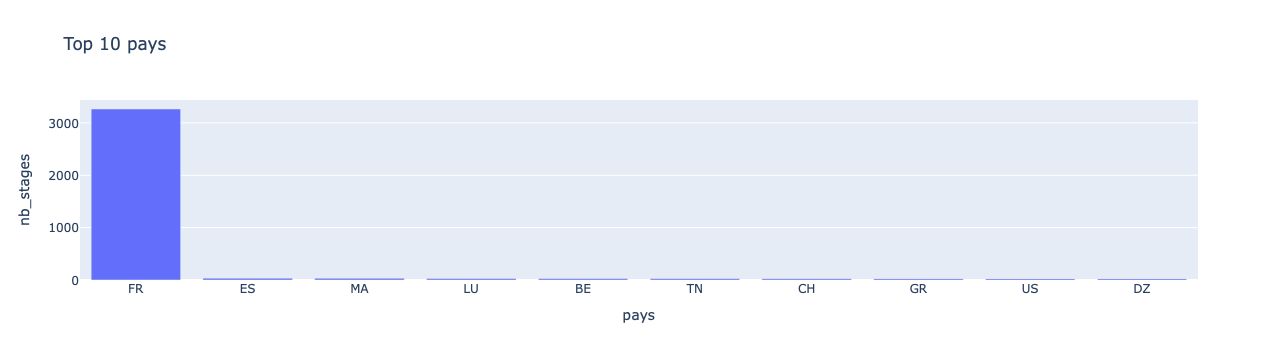

In [8]:
import plotly.express as px

cols = [r[1] for r in con.execute("PRAGMA table_info(\"stages_clean\")").fetchall()]
pays_col = "Pays" if "Pays" in cols else "pays"
query = f"SELECT {pays_col} AS pays, COUNT(*) AS nb_stages FROM stages_clean GROUP BY 1 ORDER BY nb_stages DESC LIMIT 10"
df_plot = con.execute(query).df()
fig = px.bar(df_plot, x="pays", y="nb_stages", title="Top 10 pays")
fig


## Visualisations analytiques (DuckDB)

Graphiques agreges et privacy-safe pour un etudiant (tendances, zones, domaines)
et un recruteur (entreprises recurrents, marche global).


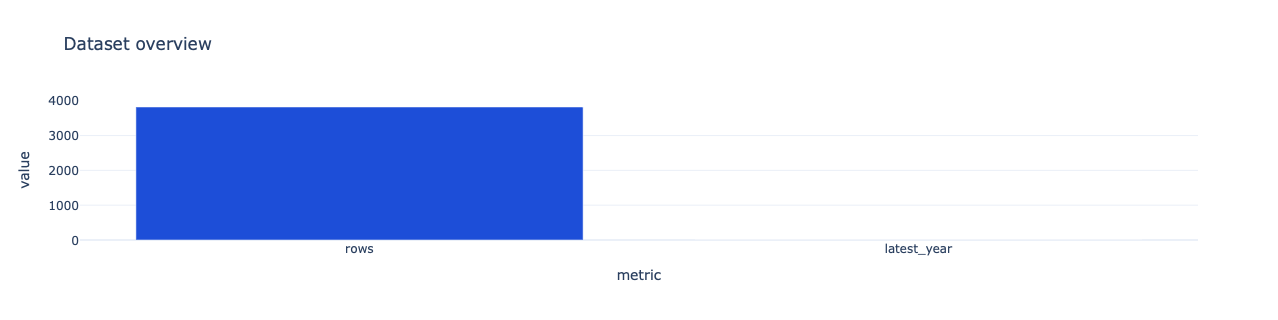

In [9]:
import duckdb
import plotly.express as px
import plotly.graph_objects as go
from scripts.config import DUCKDB_PATH

px.defaults.template = "plotly_white"
px.defaults.color_discrete_sequence = ["#1D4ED8"]

con = duckdb.connect(str(DUCKDB_PATH), read_only=True)
tables = {r[0] for r in con.execute("SHOW TABLES").fetchall()}
cols = []
if "stages_clean" in tables:
    cols = [r[1] for r in con.execute("PRAGMA table_info(\"stages_clean\")").fetchall()]

def show_df(query, params=None):
    df = con.execute(query, params or []).df()
    df.columns = [str(c).lower() for c in df.columns]
    return df

def empty_fig(title, subtitle):
    fig = go.Figure()
    fig.add_annotation(text=subtitle, x=0.5, y=0.5, showarrow=False)
    fig.update_layout(title=title, height=360)
    return fig

def year_expr():
    parts = []
    if "Promotion" in cols:
        parts.append("regexp_extract(CAST(Promotion AS VARCHAR), '(20\\d{2})', 1)")
    if "Sujet" in cols:
        parts.append("regexp_extract(CAST(Sujet AS VARCHAR), '(20\\d{2})', 1)")
    if not parts:
        return "NULL"
    joined = ", ".join(parts)
    return "NULLIF(COALESCE(" + joined + "), '')"

YEAR_EXPR = year_expr()
latest_year = None
if "mart_trends" in tables:
    latest_year = con.execute("SELECT MAX(annee) FROM mart_trends").fetchone()[0]
elif YEAR_EXPR != "NULL":
    latest_year = con.execute(
        "SELECT MAX(CAST(" + YEAR_EXPR + " AS INTEGER)) FROM stages_clean"
    ).fetchone()[0]

# KPI overview
total_rows = 0
if "stages_clean" in tables:
    total_rows = con.execute("SELECT COUNT(*) FROM stages_clean").fetchone()[0]
df_kpi = {"metric": ["rows", "latest_year"], "value": [total_rows, latest_year or 0]}
fig = px.bar(df_kpi, x="metric", y="value", title="Dataset overview")
fig.update_layout(height=320)
fig


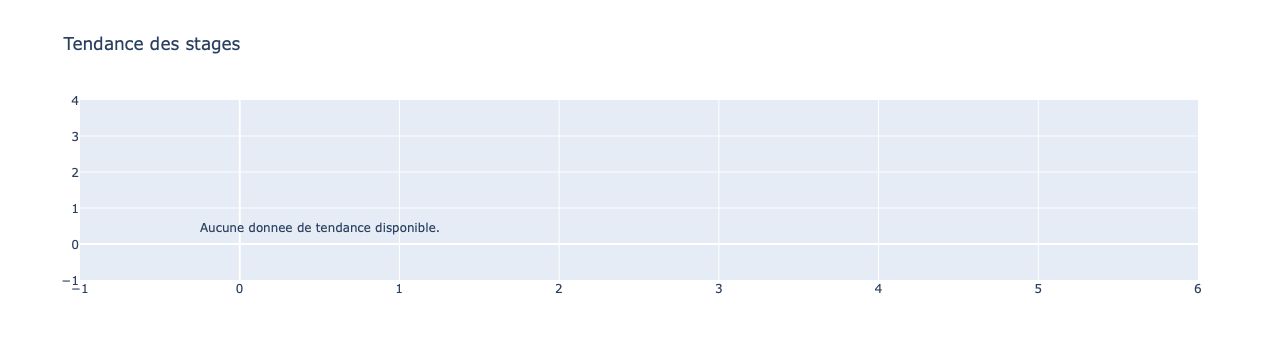

In [10]:
if "mart_trends" in tables:
    df_trends = show_df("SELECT annee, nb_stages FROM mart_trends ORDER BY annee")
elif YEAR_EXPR != "NULL":
    df_trends = show_df(
        f"SELECT CAST({YEAR_EXPR} AS INTEGER) AS annee, COUNT(*) AS nb_stages "
        f"FROM stages_clean WHERE {YEAR_EXPR} IS NOT NULL GROUP BY 1 ORDER BY 1"
    )
else:
    df_trends = None

if df_trends is None or df_trends.empty:
    fig = empty_fig("Tendance des stages", "Aucune donnee de tendance disponible.")
else:
    fig = px.line(df_trends, x="annee", y="nb_stages", markers=True,
                  title="Tendance des stages (toutes annees)")
    fig.update_layout(height=360)
fig


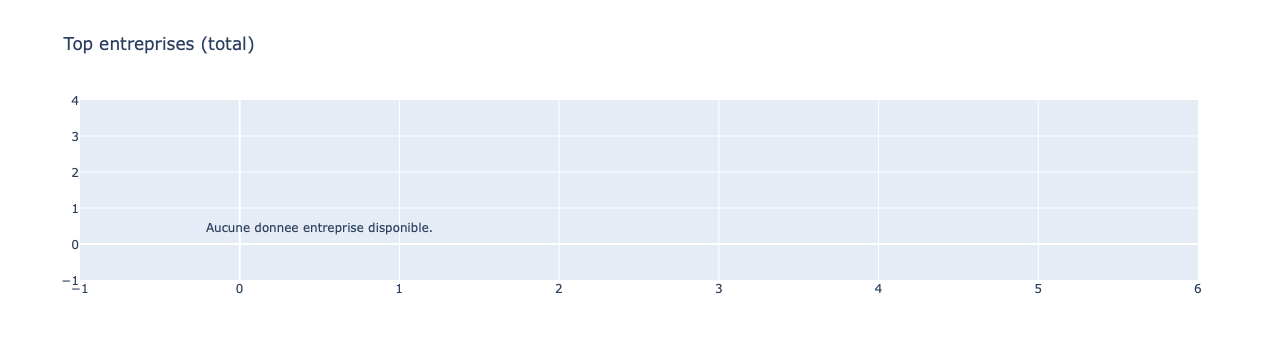

In [11]:
if "mart_top_companies" in tables:
    df_top_total = show_df(
        "SELECT entreprise, SUM(nb_stages) AS nb_stages "
        "FROM mart_top_companies GROUP BY entreprise "
        "ORDER BY nb_stages DESC LIMIT 10"
    )
elif "Société" in cols or "Societe" in cols:
    ent_col = "\"Société\"" if "Société" in cols else "Societe"
    df_top_total = show_df(
        f"SELECT {ent_col} AS entreprise, COUNT(*) AS nb_stages "
        "FROM stages_clean GROUP BY 1 ORDER BY nb_stages DESC LIMIT 10"
    )
else:
    df_top_total = None

if df_top_total is None or df_top_total.empty:
    fig = empty_fig("Top entreprises (total)", "Aucune donnee entreprise disponible.")
else:
    fig = px.bar(df_top_total, x="entreprise", y="nb_stages",
                 title="Top entreprises (total 2023-2025)")
    fig.update_layout(height=360)
fig


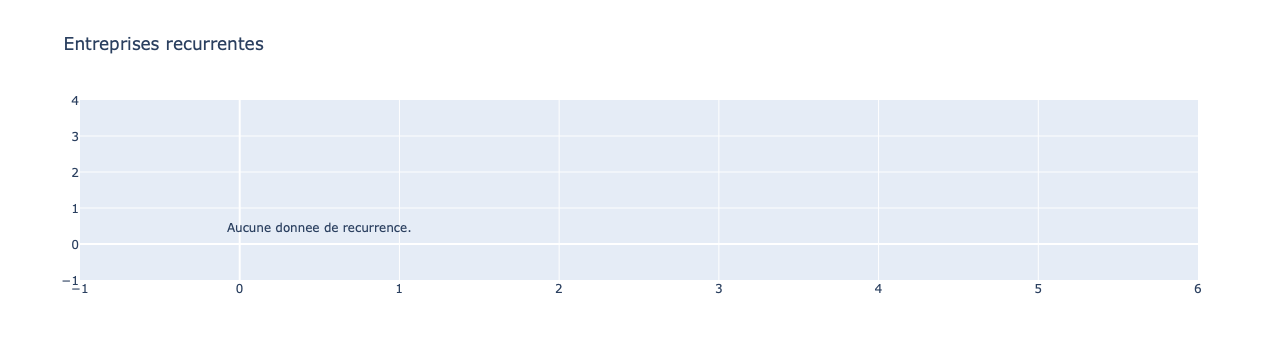

In [12]:
if "mart_top_companies" in tables:
    df_recur = show_df(
        "SELECT entreprise, COUNT(DISTINCT annee) AS nb_annees, "
        "SUM(nb_stages) AS total FROM mart_top_companies "
        "GROUP BY entreprise ORDER BY nb_annees DESC, total DESC LIMIT 20"
    )
else:
    df_recur = None

if df_recur is None or df_recur.empty:
    fig = empty_fig("Entreprises recurrentes", "Aucune donnee de recurrence.")
else:
    fig = px.scatter(df_recur, x="nb_annees", y="total", text="entreprise",
                     title="Entreprises recurrentes (multi-annees)")
    fig.update_traces(textposition="top center")
    fig.update_layout(height=420)
fig


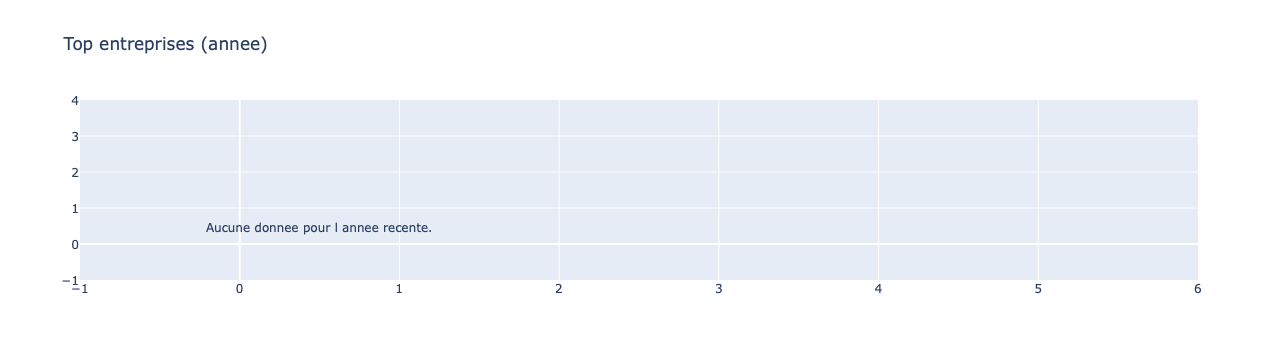

In [13]:
if "mart_top_companies" in tables and latest_year is not None:
    df_top_year = show_df(
        "SELECT entreprise, nb_stages FROM mart_top_companies WHERE annee = ? "
        "ORDER BY nb_stages DESC LIMIT 10",
        [latest_year],
    )
else:
    df_top_year = None

if df_top_year is None or df_top_year.empty:
    fig = empty_fig("Top entreprises (annee)", "Aucune donnee pour l annee recente.")
else:
    fig = px.bar(df_top_year, x="entreprise", y="nb_stages",
                 title=f"Top entreprises (annee {latest_year})")
    fig.update_layout(height=360)
fig


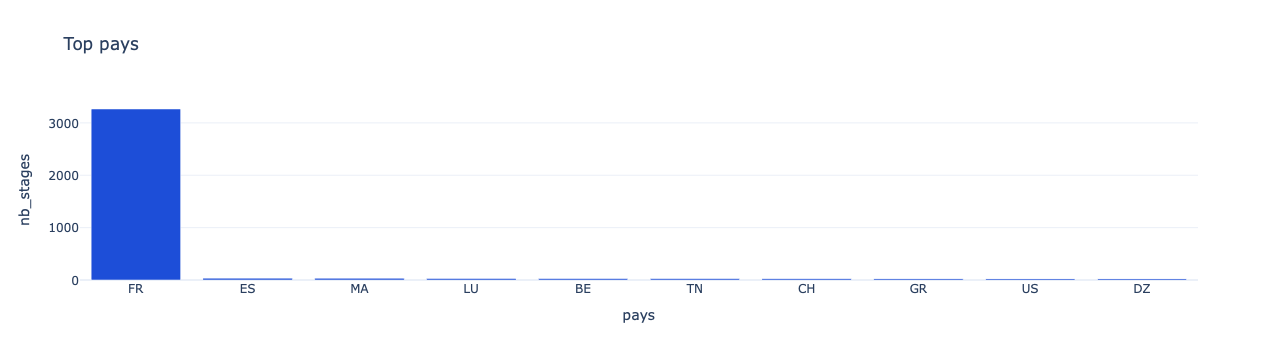

In [14]:
if "mart_geo" in tables and latest_year is not None:
    df_geo = show_df(
        "SELECT pays, nb_stages FROM mart_geo WHERE annee = ? "
        "ORDER BY nb_stages DESC LIMIT 10",
        [latest_year],
    )
elif "Pays" in cols or "pays" in cols:
    pays_col = "Pays" if "Pays" in cols else "pays"
    df_geo = show_df(
        f"SELECT {pays_col} AS pays, COUNT(*) AS nb_stages "
        "FROM stages_clean GROUP BY 1 ORDER BY nb_stages DESC LIMIT 10"
    )
else:
    df_geo = None

if df_geo is None or df_geo.empty:
    fig = empty_fig("Top pays", "Aucune donnee geographique disponible.")
else:
    title = f"Top pays (annee {latest_year})" if latest_year else "Top pays"
    fig = px.bar(df_geo, x="pays", y="nb_stages", title=title)
    fig.update_layout(height=360)
fig


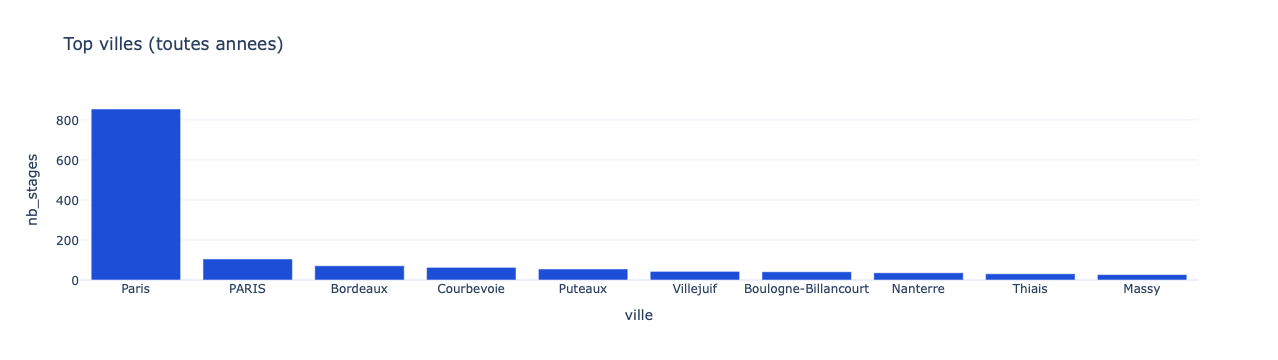

In [15]:
if "Ville" in cols:
    df_city = show_df(
        "SELECT Ville AS ville, COUNT(*) AS nb_stages "
        "FROM stages_clean GROUP BY ville ORDER BY nb_stages DESC LIMIT 10"
    )
else:
    df_city = None

if df_city is None or df_city.empty:
    fig = empty_fig("Top villes", "Aucune donnee de ville disponible.")
else:
    fig = px.bar(df_city, x="ville", y="nb_stages",
                 title="Top villes (toutes annees)")
    fig.update_layout(height=360)
fig


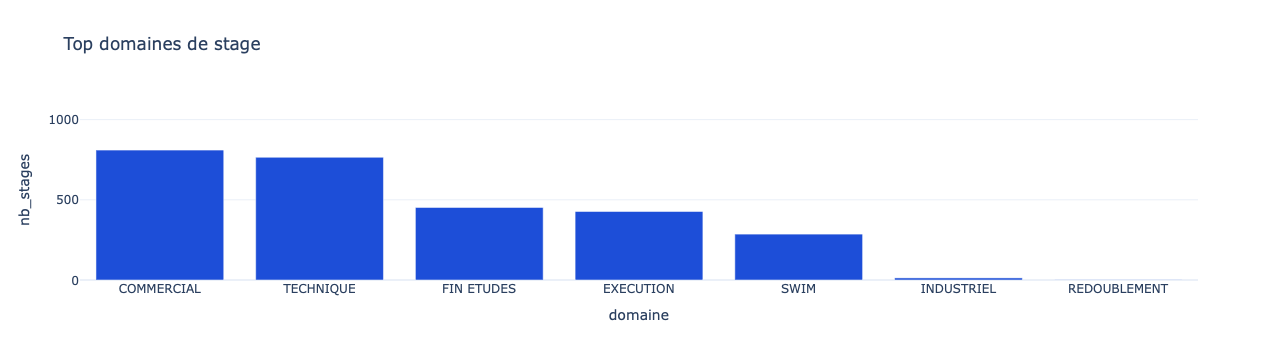

In [16]:
if "Domaine de stage" in cols:
    domain_col = "\"Domaine de stage\""
    df_domain = show_df(
        f"SELECT {domain_col} AS domaine, COUNT(*) AS nb_stages "
        "FROM stages_clean GROUP BY 1 ORDER BY nb_stages DESC LIMIT 10"
    )
else:
    df_domain = None

if df_domain is None or df_domain.empty:
    fig = empty_fig("Top domaines", "Aucune donnee de domaine disponible.")
else:
    fig = px.bar(df_domain, x="domaine", y="nb_stages",
                 title="Top domaines de stage")
    fig.update_layout(height=360)
fig


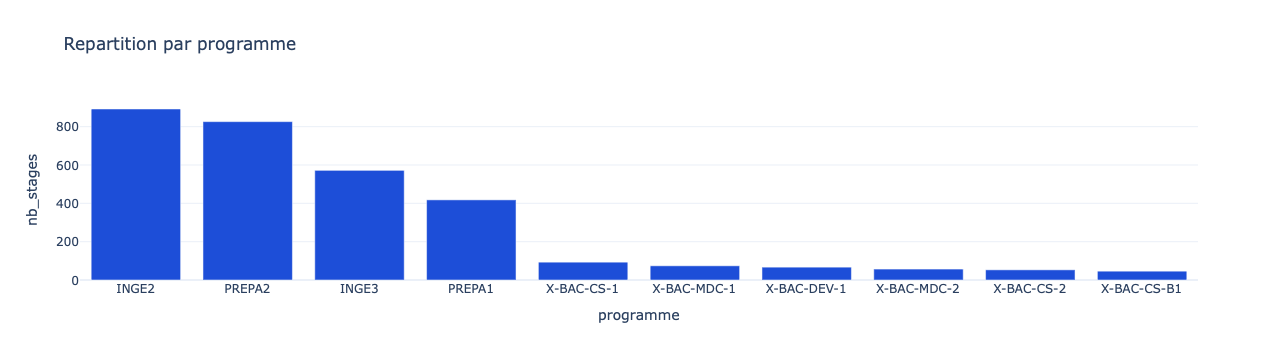

In [17]:
if "Programme" in cols:
    df_prog = show_df(
        "SELECT Programme AS programme, COUNT(*) AS nb_stages "
        "FROM stages_clean GROUP BY 1 ORDER BY nb_stages DESC LIMIT 10"
    )
else:
    df_prog = None

if df_prog is None or df_prog.empty:
    fig = empty_fig("Programmes", "Aucune donnee de programme disponible.")
else:
    fig = px.bar(df_prog, x="programme", y="nb_stages",
                 title="Repartition par programme")
    fig.update_layout(height=360)
fig


## Conclusion

Prochaines etapes:
1. Supprimer/anonymiser les colonnes PII des la sortie du brut.
2. Nettoyer et normaliser les colonnes texte.
3. Charger la donnee propre dans DuckDB pour construire des marts analytiques.
